# Assignment 2: Fourier Analysis

## 0: Introduction

The following is adapted from chapter 12 of Numerical recipes, which may be reviewed if you would like a more complete introduction.

Imagine we have a process descibed as a function of time, $g(t)$. We say that this process is described in the _time domain_. We may also describe this process in the frequency domain, where the process is described by a specific amplitude $\tilde{g}(f)$. We can go back and forth between representations using Fourier transforms,

$$
\begin{align}
\tilde{g}(f) &= \int_{-\infty}^\infty g(t) e^{2\pi i f t}dt\\
g(t) &= \int_{-\infty}^{\infty} \tilde{g}(f) e^{-2\pi i f t}df.
\end{align}
$$

In many physics applications, we perform Fourier transformations between position and momentum domains.

### Discrete Fourier Transforms

Consider a periodic function $h$, $h(x) = h(x+L)$ from some period $L$. We may represent this function as a Fourier series 

$$
h(x) = \sum_{k=-\infty}^{\infty} \tilde{h}_k e^{-2\pi i f_k x}, f_k = k/L.
$$

The Fourier coefficients $\tilde{h}_k$ may be recovered using the Fourier transform equation above.

We can map a set of $N$ time-domain values $h_i$ onto a set of $N$ frequency-domain functions by the transformation

$$
\tilde{h}_k = \frac{1}{N} \sum_{i=0}^{N-1} h_j e^{2\pi i f_k x_j},
$$

where $x_j = jL/N$ and $f_k = k/L$.


### FFTs

The Fast Fourier Transform (FFT) reduce the compute time from $O(N^2)$ to $O(N \log N)$, making them a lot more accessible for a variety of computations. Scipy has an implementation of FFT that we can make use of.

### PSDs

Parseval's theorem tells us that the total power of a signal is the same regardless of which domain we compute it in,

$$
\texttt{total power} = \int |g(t)|^2 dt = \int |\tilde{g}(f)|^2 dt.
$$

Often, one wants to compute how much power is contained in the interval $[f, f+df]$. We then regard the frequency as varying from $0$ to $\infty$ and define the one-sided power spectral density (PSD)

$$
P_g(f) = |\tilde{g}(f)|^2 + |\tilde{g}(-f)|^2 .
$$

### SNR

The signal-to-noise ratio compares the level of the desired signal to the level of the background noise.

## 1: SETI signals

SETI (Search for Extra Terrestrial Intelligence) analyzes signals collected from telescopes for messages from extraterrestrial civilizations. We are providing you with a ficticious time series of $32768$ elements sampled at intervals of 1 ms, representing the output of a telescope in Arecibo, Puerto Rico. 

#### (1) Import and plot the data as a function of time. Does it reveal in obvious features? 

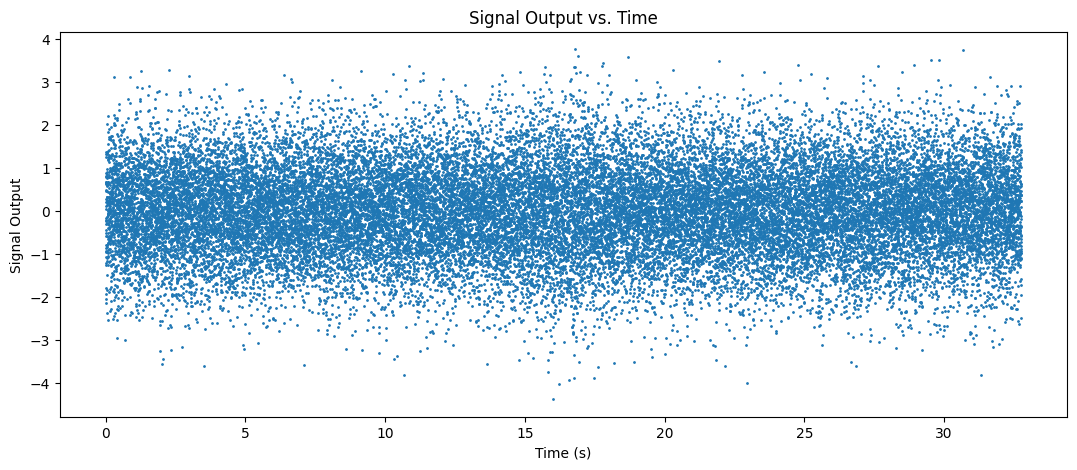

In [1]:
import numpy as np
from matplotlib import pyplot as plt

signals = np.loadtxt("arecibo1.txt")

# We would prefer to have the time plotted in minutes
N = len(signals)
timestep = 0.001
times = np.arange(0,N*timestep,timestep)

plt.figure(figsize=(13,5))
plt.xlabel("Time (s)")
plt.ylabel("Signal Output")
plt.title("Signal Output vs. Time")
signal_plot = plt.scatter(times, signals,s=1)


## Observations
The signals seems to be roughly clustered from $-2$ to $2$, but there are many values that lie outside of this range too. It is difficult to tell an exact or definite frequency just from looking at this data, and there seem to be no obvious features in that sense.

This data actually has a roughly definite frequency, it is just difficult to see in the time domain. If we perform an FFT, the power will be reassembled into a few nearby Fourier coefficients.

#### (2) Perform the FFT and plot the result. Identify the frequency in Hertz (taking the point where the magnitude of the FFT is maximal to be the frequency).

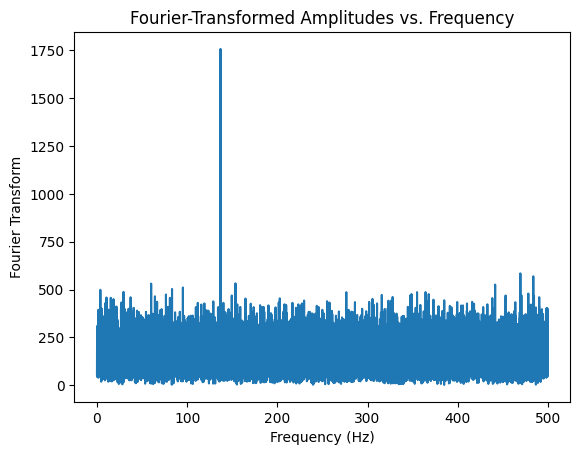

In [3]:
from scipy.fft import fft, fftfreq
# Compute the FFT of the signal
fast_fourier = fft(signals)
# Compute the frequency bins
frequencies = fftfreq(N, d=timestep)[:N//2]

# Plotting only the positive frequencies, since the positive and negative frequencies are duplicates
plt.xlabel("Frequency (Hz)")
plt.ylabel("Fourier Transform")
plt.title("Fourier-Transformed Amplitudes vs. Frequency")
frequency_plot= plt.plot(frequencies, np.abs(fast_fourier[:N//2]))

In [5]:
# Identify the maximum frequency (in mHz)
max_frequency_bin = np.argmax(np.abs(fast_fourier[:N//2]))
print(frequencies[max_frequency_bin])

136.993408203125


## Results
From the graph and the output, we see that this data has a roughly definite frequency close to $137 \text{ H}$. Because the samping rate is $1000$ samples/s, this means that the phase of the data should be roughly periodic in every $1000/137\approx 7.3$ sample points or so.

#### (3) Zero out the non-significant entries from the Fourier transform. Perform an inverse Fourier transform and plot the results. What do you notice?
To do this, we will implement a threshold of a Fourier transform of 600 -- anything below this will be set to zero, which has the effect of zeroing out the non-significant entries from the Fourier transform.

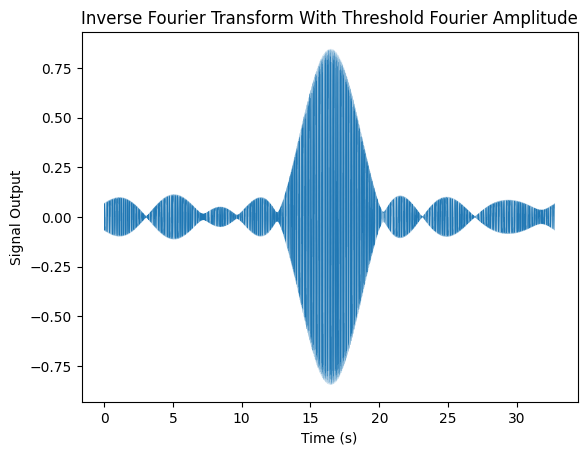

In [7]:
from scipy.fft import ifft
# We will let values greater than 600 be significant
threshold = 600

# Remove values in the spectrum below the threshold
for i in range(len(np.abs(fast_fourier))):
    if np.abs(fast_fourier[i]) < threshold:
       fast_fourier[i] = 0
inverse_fourier = ifft(fast_fourier)
plt.xlabel("Time (s)")
plt.ylabel("Signal Output")
plt.title("Inverse Fourier Transform With Threshold Fourier Amplitude")

# Plot with an explicit reference to real because of imaginary roundoff. The line width is chosen to be small in order to see the finer details
inverse_plot = plt.plot(times, inverse_fourier.real, linewidth=0.06)

## Observations
Although the frequency determined above is close to $137 \text{ Hz}$, we notice that the amplitudes of the signal output vary across time. In particular, there is a wavy nature to the envelope amplitudes. There is a large center envelope beginning at $\approx 13$ seconds and ending at $\approx 20$ seconds and a multitude of smaller envelopes on each side.

## 2: Some noisy (literally) data

We have some data (in the attached wav file) that has been captured from a noisy room. It sounds, and looks like, there may be no distinct frequency. However, Fourier/spectral techniques may reveal otherwise. 

#### (4) Make use of scipy's io functions to read in and plot the data in the included wav file. Add a sine wave to the data of the given form and plot the signal (our generated sine wave), the recorded noise, and the total on the same time series plot.

In this step, we are injecting a 'true signal' into our data, to make the subsequent frequency analysis a bit clearer. Pick an amplitude, frequency, and phase, and add it to the noise from the wav file.

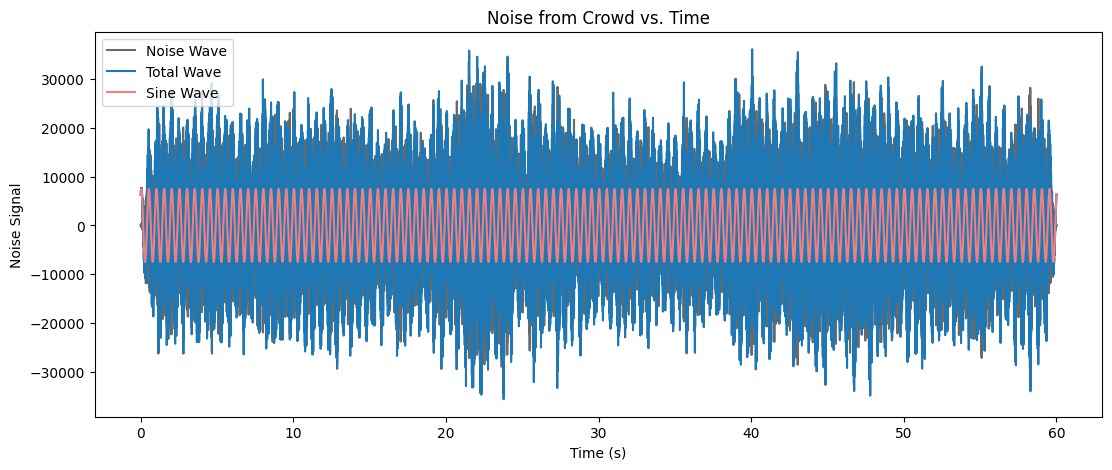

In [9]:
import math
from scipy.io import wavfile
sample_rate, data = wavfile.read("crowd-talking-1.wav")

# These times are given in seconds
noise_times = np.linspace(0,len(data)/sample_rate,len(data))

plt.figure(figsize=(13,5))
plt.xlabel("Time (s)")
plt.ylabel("Noise Signal")
plt.title("Noise from Crowd vs. Time")

# By inspecting the data output, we see that there are two audio channels. We will just use the data from the first channel
noise_data = data[:,0]
noise_plot = plt.plot(noise_times, noise_data, color="dimgray", label="Noise Wave")

# Plotting a sine wave with an amplitude A, phase phi, and frequency f (Hz)
A = 7500
phi = 1
f = 2
sine_wave = A*np.sin(2*math.pi*f*noise_times+phi)

# Plotting the sum of the noise and the sine wave
total_plot = plt.plot(noise_times, noise_data + sine_wave, label="Total Wave")
sine_plot = plt.plot(noise_times, sine_wave, color="lightcoral", label = "Sine Wave")

legend = plt.legend(loc="upper left")


#### (5) Welch's method can be used to perform spectral density estimation. 

* Use scipy's implementation of Welch's method to compute and plot a PSD for the noisy data.
* Do you have any observations about the shape of the data?

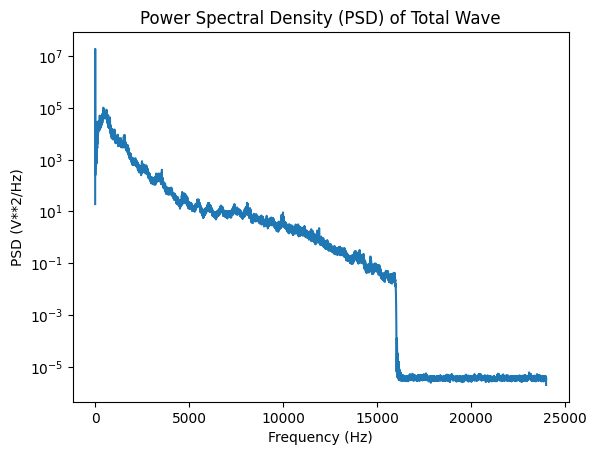

In [11]:
from scipy.signal import welch

# In performing Welch's method, we set nperseg to be the sample_rate, which means that the frequency bins are spaced 1 Hz apart.
# This is chosen so that the injected frequency is more easily seen
f_total, Pxx_den_total = welch(noise_data + sine_wave, sample_rate, nperseg=sample_rate)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (V**2/Hz)")
plt.title("Power Spectral Density (PSD) of Total Wave")

# Plot the PSD on a logarithmic scale for visibility
PSD_total = plt.semilogy(f_total, Pxx_den_total)

## Observations
- There is a very large spike when the frequency is at $2 \text{ Hz}$. This makes sense, because the sine wave that we previously added to the noise was set at a frequency of $2 \text{ Hz}$.
- The PSD as a function of the frequency is generally decreasing, and there is a rather abrupt decrease at $\approx 16000 \text{ Hz}$.

#### (6) Now compare the PSDs of the 2 quantities: the noise, and the noise with the sine wave. The frequency resolution of the PSD is inversely proportional to the length of the FFT. Use the 'nperseg' quantity to adjust the FFT length until the injected signal is easily visible in the plot.

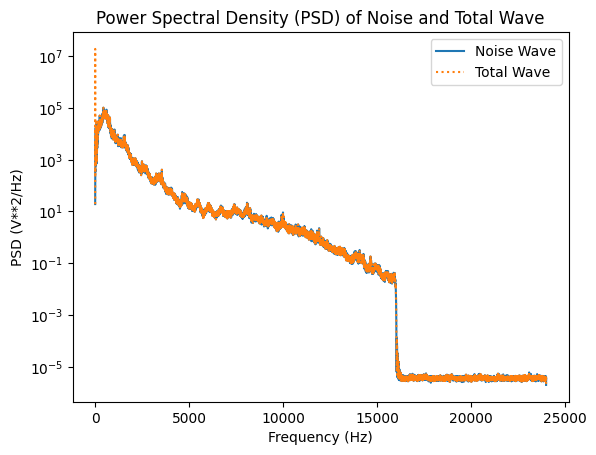

In [13]:
# Now, perform Welch's method on just the noise, with the same parameters are before
f_noise, Pxx_den_noise = welch(noise_data, sample_rate, nperseg=sample_rate)

plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (V**2/Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (V**2/Hz)")
plt.title("Power Spectral Density (PSD) of Noise and Total Wave")
PSD_noise = plt.semilogy(f_noise, Pxx_den_noise, label="Noise Wave")
PSD_total = plt.semilogy(f_total, Pxx_den_total,linestyle="dotted",label="Total Wave")

legend = plt.legend(loc="upper right")

## Observations
- Both PSDs are remarkably similar when considering frequencies greater than a few Hertz.
- The major difference lies in the PSD around $2\text{ Hz}$, where the total wave (including the injected sine wave) displays a PSD of greater than $10^7 \text{ V}^2\text{/Hz}$, while the wave containing just the noise does not display this feature. 

#### Let's say we are trying to estimate the amplitude and frequency of this sine wave. How might we do it?

One familiar technique is fitting. However, in this case the signal is much smaller than the noise, so directly fitting the data would not converge with any accuracy or precision.

Given a model for the signal that it has a frequency "near" f_sig, we can use the following recipe, which is known as 'heterodyne detection':

$$z_{estimate} = \int_{t_0}^{t_1} data(t) * LO(t) dt$$

where $$LO(t) = e^{i \omega t}$$

this is essentially a single frequency Fourier Transform. By averaging over a sufficiently long time, all of the contributions from frequencies other than $f_{sig}$ will disappear.

In Python, we can implement this performing a "moving average" on the integrand. The output, (smoothed(z_estimate)), will give a running estimate of the cosine and sine components of the signal. These can be readily turned into estimates of the amplitude and frequency/phase of the signal.

#### (7) Now calculate the uncertainty in the amplitude and the phase estimate by computing the variance of the resulting heterodyned signal.

A heterodyne is a signal frequency that is created by combining or mixing two other frequencies.

* First, write a function that computes the moving average over a given number of data points. **Hint**: Think about how you can use a convolution to compute this average

* Use this function to compute estimates for the amplitude and phase of the signal.

In [15]:
# Computes the moving average of 'data', using a window size of N
def compute_moving_average(data, N):
    # The second array that we will slide. It is uniform since we are averaging, and normalized so that the sum of all elements is 1
    v = np.ones(N)/N 

    # Returns twice the convolution between the data and the uniform kernel. The factor of two is included because the result from the convolution
    # will be approximately 1/2 of the desired amplitude, due to the fact that when multiplying the data (which, due to the injected sine wave,
    # has a Fourier component of sin(2*pi*ft)) with the local oscillator (which is by definition an oscillator of frequency f), there will be a factor
    # of sin^2, which averages to 1/2 over many cycles. Thus we multiply by 2 to get the desired amplitude.
    return 2*np.convolve(data, v, mode='same')

# Let us now find the cosine and sine component of the frequency at f_sig=f=2 Hz.
data_cos = (noise_data + sine_wave) * np.cos(2*math.pi*f*noise_times)
data_sin = (noise_data + sine_wave) * np.sin(2*math.pi*f*noise_times)

# We choose a reasonably large windows size
window_size = 3000
smoothed_cos = compute_moving_average(data_cos, window_size)
smoothed_sin = compute_moving_average(data_sin, window_size)

# We computed the moving averages above, and we now take the mean of these values to get a single, representative value for the cosine and sine components
cos_amplitude = np.mean(smoothed_cos)
sin_amplitude = np.mean(smoothed_sin)

amplitude = np.sqrt(cos_amplitude**2 + sin_amplitude**2)
phase = np.arctan2(cos_amplitude, sin_amplitude)

print("The cosine amplitude of the wave is " + str(np.round(cos_amplitude, decimals=2)) + " and the sine component of the wave is " + str(np.round(sin_amplitude, decimals=2)) + ".")
print("The estimated inject sine wave amplitude is " + str(np.round(amplitude, decimals=2)) + " and the estimated phase is " + str(np.round(phase,decimals=6)) + " radians.")

The cosine amplitude of the wave is 6307.39 and the sine component of the wave is 4054.24.
The estimated inject sine wave amplitude is 7498.0 and the estimated phase is 0.999516 radians.


## Uncertainty
The estimated amplitude of the the injected wave was calculated as 
$$A=\sqrt{cos_{amplitude}^2+sin_{amplitude}^2},$$
where $cos_{amplitude}$ and $sin_{amplitude}$ denote the mean amplitude of the cosine and sine components of the wave, respectively (where we first smoothed the data with a convolution, then averaged over the data). The general formula for the variance of $A=f(x,y)$ is 
$$\text{Var}(A)=\left(\frac{\partial f}{\partial x}\right)^2\text{Var}(x)+\left(\frac{\partial f}{\partial y}\right)^2\text{Var}(y),$$ where in this case we have that $f(x,y)=\sqrt{x^2+y^2}$, $x=cos_{amplitude}$ and $y=sin_{amplitude}$. Carrying out the derivatives, we see that 
$$\text{Var}(A)=\frac{cos_{amplitude}^2}{A^2}\text{Var}(cos_{amplitude})+\frac{sin_{amplitude}^2}{A^2}\text{Var}(sin_{amplitude}).$$ 

Recall the trigonometric identity that $\cos_{amplitude}\cos(\omega  t)+\sin_{amplitude}\sin(\omega t)=A\sin(\omega t+\phi)$, where $\phi=\tan^{-1}(\cos_{amplitude}/\sin_{amplitude})$, which is the phase. Carrying a similar calculation as above, we find that the variance in the phase is given by 
$$\text{Var}(\phi)=\frac{sin_{amplitude}}{A^2}\text{Var}(cos_{amplitude})-\frac{cos_{amplitude}}{A^2}\text{Var}(sin_{amplitude}).$$

Finally, to find $\text{Var}(cos_{amplitude})$ and $\text{Var}(sin_{amplitude})$, we are finding the variance of a mean, since $cos_{amplitude}$ and $sin_{amplitude}$ are the means of the $smoothed_{cos}$ and $smoothed_{sin}$ arrays, respectively. Thus, we have that 
$$\text{Var}(cos_{amplitude})=\frac{\text{Var}(smoothed_{cos})}{N}$$ and 
$$\text{Var}(sin_{amplitude})=\frac{\text{Var}(smoothed_{sin})}{N}$$ where $N$ is the length of the $smoothed_{sin}$ and $smoothed_{cos}$ arrays.
Let us now carry out these calculations in code.

In [17]:
# Simply plug in the formulas given above
var_cos_amplitude = np.var(smoothed_cos)/len(smoothed_cos)
var_sin_amplitude = np.var(smoothed_sin)/len(smoothed_sin)
var_A = (cos_amplitude**2/amplitude**2)*var_cos_amplitude + (sin_amplitude**2/amplitude**2)*var_sin_amplitude
var_phi = (sin_amplitude/amplitude**2)*var_cos_amplitude - (cos_amplitude/amplitude**2)*var_sin_amplitude
print("The variance in the amplitude is " + str(np.round(var_A, decimals=3)) + " and the variance in the phase is " + str(np.round(var_phi, decimals=6)) + " radians.")

The variance in the amplitude is 7.915 and the variance in the phase is -0.000319 radians.


Due to the relatively small variances, we can be confident that the injected sine wave has an amplitude close to $7500$ and a phase close to $1 \text{ radian}$. Indeed, this matches the inputs we gave earlier, which means that the model is self-consistent.